# Layer 2: Collapsed Pillar Analysis

This notebook generates specific plots to analyze and justify the clustering of 'Collapsed' pillars in Layer 2.

**Focus:**
1. **Feature Scatter:** Darkness Ratio vs. Normalized Area
2. **Feature Distributions:** Histograms of key features
3. **Visual Montage:** Side-by-side comparison of Good vs. Collapsed
4. **Elbow Method:** Justification for K=3

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Import our module
from layered_clustering import (
    load_tiles, extract_center_intensity, extract_darkness_area, cluster_layer
)

np.random.seed(42)
plt.rcParams.update({'font.size': 11, 'figure.dpi': 120})
RESULTS_DIR = Path('results')
RESULTS_DIR.mkdir(exist_ok=True)

DEFECT_COLORS = {'Good': '#27ae60', 'Missing': '#e74c3c', 'Collapsed': '#8e44ad'}

## 1. Prepare Data (Layer 1 -> Layer 2)

In [2]:
# Load all tiles
BASE_DIR = Path('.')
META_ATOMS_DIR = BASE_DIR / 'Meta_Atoms'
tiles = load_tiles(META_ATOMS_DIR)
print(f"Total tiles: {len(tiles)}")

# --- Run Layer 1 to remove Missing ---
X1 = extract_center_intensity(tiles)
res1 = cluster_layer(tiles, X1, 'layer_missing', n_clusters=3)

# Identify missing labels
missing_cluster = min(res1.cluster_counts, key=res1.cluster_counts.get)
missing_mask = res1.labels == missing_cluster

# Keep only non-missing for Layer 2
layer2_tiles = [t for i, t in enumerate(tiles) if not missing_mask[i]]
print(f"Tiles for Layer 2 analysis: {len(layer2_tiles)} (removed {sum(missing_mask)} Missing)")

Total tiles: 1323
Tiles for Layer 2 analysis: 1253 (removed 70 Missing)


c:\Users\srfdyz\.conda\envs\ci\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


## 2. Extract Layer 2 Features

In [3]:
# Extract features
X2 = extract_darkness_area(layer2_tiles)

# Feature names from the function: 
# [mean_int, dark_ratio, very_dark_ratio, area, norm_area]
df_layer2 = pd.DataFrame(X2, columns=['Mean Intensity', 'Darkness Ratio', 
                                      'Very Dark Ratio', 'Contour Area', 'Normalized Area'])

# Run Clustering (Ground Truth for plots)
res2 = cluster_layer(layer2_tiles, X2, 'layer_collapsed', n_clusters=3)
df_layer2['Cluster'] = res2.labels
df_layer2['Label'] = ['Collapsed' if l == res2.extracted_indices[0] 
                      else 'Good' for l in list(df_layer2.index) 
                      # Logic check: extracted_indices contains indices relative to layer2_tiles list
                      # But wait, extracted_indices is a list of integers. 
                      # Let's just use the label directly.
                     ]

# Correct label assignment
collapsed_cluster = min(res2.cluster_counts, key=res2.cluster_counts.get)
df_layer2['Label'] = df_layer2['Cluster'].apply(lambda x: 'Collapsed' if x == collapsed_cluster else 'Good/Other')

print("Cluster Counts:")
print(df_layer2['Label'].value_counts())

Cluster Counts:
Label
Good/Other    1182
Collapsed       71
Name: count, dtype: int64


c:\Users\srfdyz\.conda\envs\ci\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


## 3. Plot 1: Feature Scatter (Darkness vs Area)

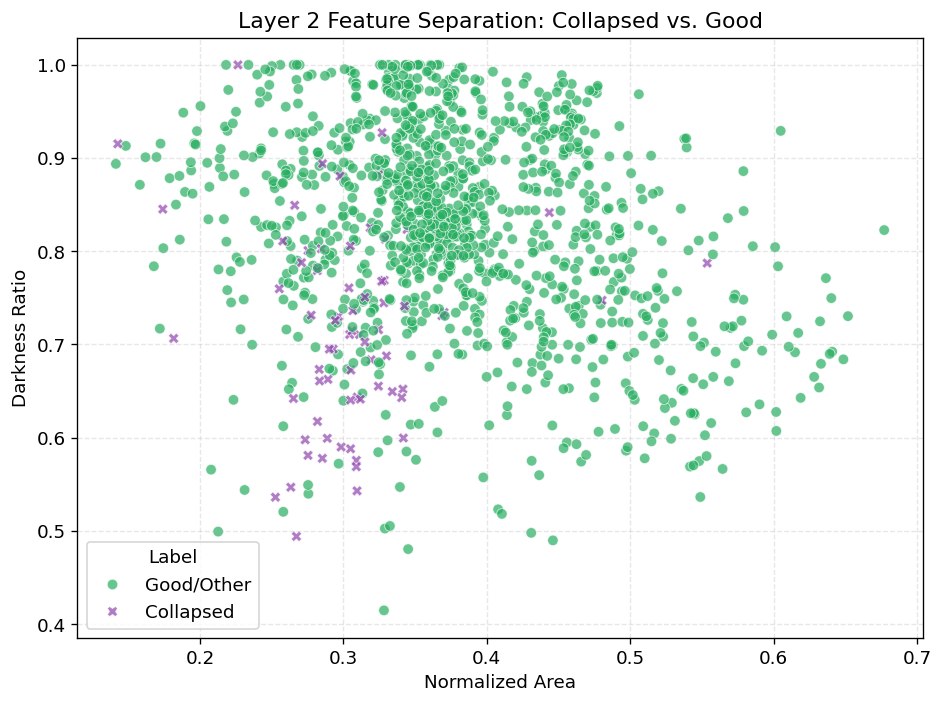

In [4]:
plt.figure(figsize=(8, 6))

sns.scatterplot(data=df_layer2, x='Normalized Area', y='Darkness Ratio', 
                hue='Label', palette={'Collapsed': '#8e44ad', 'Good/Other': '#27ae60'}, 
                style='Label', alpha=0.7, s=40)

plt.title('Layer 2 Feature Separation: Collapsed vs. Good')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'layer2_scatter_darkness_area.png', dpi=300)
plt.show()

## 4. Plot 2: Feature Histograms (Bimodal Distribution)

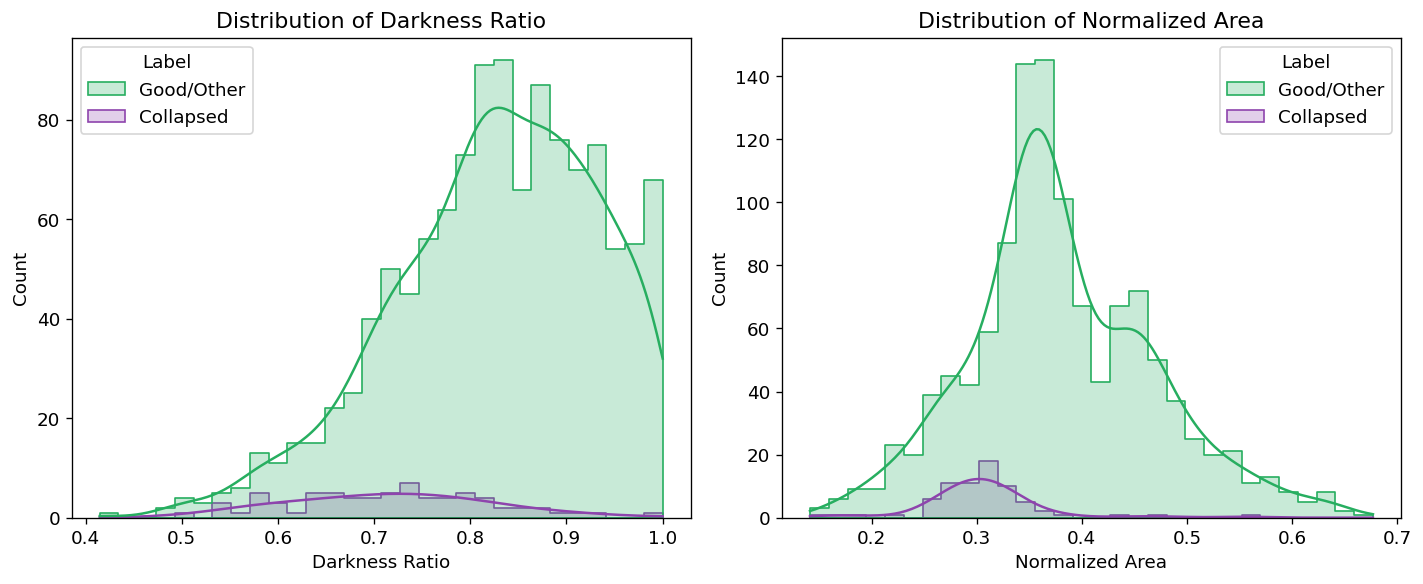

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Darkness Ratio
sns.histplot(data=df_layer2, x='Darkness Ratio', hue='Label', 
             palette={'Collapsed': '#8e44ad', 'Good/Other': '#27ae60'}, 
             kde=True, bins=30, ax=axes[0], element='step', common_norm=False)
axes[0].set_title('Distribution of Darkness Ratio')

# Normalized Area
sns.histplot(data=df_layer2, x='Normalized Area', hue='Label', 
             palette={'Collapsed': '#8e44ad', 'Good/Other': '#27ae60'}, 
             kde=True, bins=30, ax=axes[1], element='step', common_norm=False)
axes[1].set_title('Distribution of Normalized Area')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'layer2_feature_histograms.png', dpi=300)
plt.show()

## 5. Plot 3: Visual Montage (Good vs Collapsed)

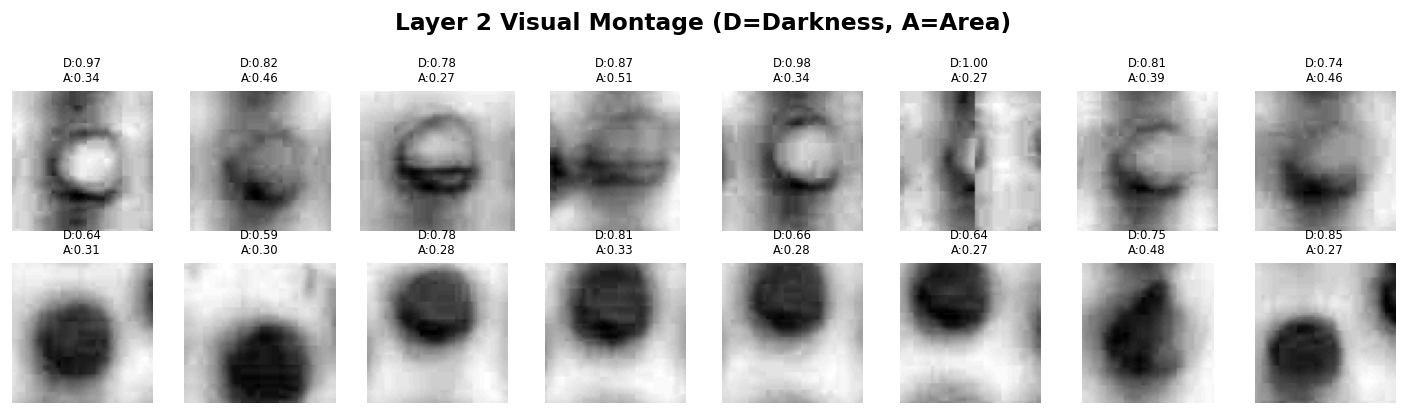

In [6]:
# Select random samples
n_samples = 8
collapsed_indices = df_layer2[df_layer2['Label'] == 'Collapsed'].sample(n_samples).index
good_indices = df_layer2[df_layer2['Label'] == 'Good/Other'].sample(n_samples).index

fig, axes = plt.subplots(2, n_samples, figsize=(n_samples*1.5, 3.5))

for i in range(n_samples):
    # Good
    ax = axes[0, i]
    idx = good_indices[i]
    tile = layer2_tiles[idx]
    ax.imshow(tile.image, cmap='gray')
    ax.axis('off')
    if i == 0:
        ax.set_ylabel('Good/Other', fontweight='bold', color='#27ae60', fontsize=12)
    # Annotate with feature value
    ax.set_title(f"D:{df_layer2.loc[idx, 'Darkness Ratio']:.2f}\nA:{df_layer2.loc[idx, 'Normalized Area']:.2f}", fontsize=7)

    # Collapsed
    ax = axes[1, i]
    idx = collapsed_indices[i]
    tile = layer2_tiles[idx]
    ax.imshow(tile.image, cmap='gray')
    ax.axis('off')
    if i == 0:
        ax.set_ylabel('Collapsed', fontweight='bold', color='#8e44ad', fontsize=12)
    ax.set_title(f"D:{df_layer2.loc[idx, 'Darkness Ratio']:.2f}\nA:{df_layer2.loc[idx, 'Normalized Area']:.2f}", fontsize=7)

plt.suptitle('Layer 2 Visual Montage (D=Darkness, A=Area)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'layer2_visual_montage.png', dpi=300)
plt.show()

## 6. Plot 4: Elbow Method Justification

c:\Users\srfdyz\.conda\envs\ci\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\srfdyz\.conda\envs\ci\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\srfdyz\.conda\envs\ci\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\srfdyz\.conda\envs\ci\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have

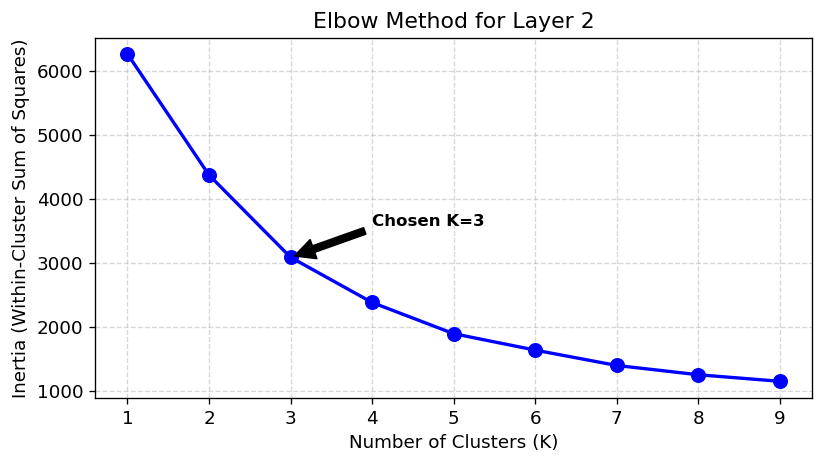

In [7]:
# Prepare data for elbow plot
X2_clean = np.nan_to_num(X2, nan=0, posinf=0, neginf=0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X2_clean)

inertias = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Layer 2')
plt.grid(True, linestyle='--', alpha=0.5)

# Annotate elbow
plt.annotate('Chosen K=3', xy=(3, inertias[2]), xytext=(4, inertias[2]+500),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'layer2_elbow_plot.png', dpi=300)
plt.show()